# Feature Engineering
- Data is already cleaned and lemmatised from the previous step
- In this notebook, I will be creating the features which will be used as input for various clustering methods 

## Overview:

1. Create TF-IDF embedding.
2. Use TF-IDF embeddings to perform topic modelling and generate topic probability features for each lemmatised_title.
3. Create GloVe embeddings for semantic representation of title.
4. t-SNE for dimensionality reduction and visualization
5. Save generated features and use for clustering.

## 1. Setup Environment and Imports

In [12]:
import logging
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from typing import Optional
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
import joblib
import pickle
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)

## 2. Load data
- Data is already cleaned, filtered and lemmatized using previous steps
- Contains only Natural disaster related events

In [3]:
df = pd.read_csv("../data/3. Fully Cleaned events with lemmatised title.csv")


In [4]:
# As the objective is to cluster the article title, we only need the article title related columns
df = df[['title', 'cleaned_title', 'is_natcat','lemmatised_title']]
df.head()

,title,cleaned_title,is_natcat,lemmatised_title
0,Japan earthquakes : Coastal residents told to ...,japan earthquakes coastal residents told to ev...,True,earthquake coastal resident tell evacuate amid...
1,New state report : Wildfire smoke increased de...,new state report wildfire smoke increased deat...,True,new state report wildfire smoke increase death...
2,In Photos : NASA Juno Flies Just 930 Miles Abo...,in photos nasa juno flies just 930 miles above...,True,photo nasa juno fly mile volcano jupiter viole...
3,2023 finishes as 3rd warmest in central Indian...,2023 finishes as 3rd warmest in central indian...,True,finish warm central tornado statewide
4,New Year Day flood alerts issued in Cambridges...,new year day flood alerts issued in cambridges...,True,new year day flood alert issue cambridgeshire ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18490 entries, 0 to 18489
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             18490 non-null  object
 1   cleaned_title     18490 non-null  object
 2   is_natcat         18490 non-null  bool  
 3   lemmatised_title  18490 non-null  object
dtypes: bool(1), object(3)
memory usage: 451.5+ KB


Can see we have 18490 articles in our dataset which are classified as Nat-cat events from the previous notebook.

## Feature Engineering

1. Create TF-IDF Features:
    * The idea is to create a TF-IDF features on lemmatised titles, such that we can use it in LDA to observe the overall topics from the lemmatised titles.

2. Create LDA Features
    * Create and obsertve LDA topics which are most relevant to the overall article titles. (This helps to understand the topics mostly present in the overall titles) 
    * Use LDA to create meaningful, low-dimensional representations of text in vector form (i.e., topic probabilities - probability of title belonging to each topic) and this is used as a feature in clustering algorithms. 

3. Create Glove Embedding Features:
    * Glove helps to get semantic relationship between words of a title. And using TF-IDF, create Glove Embeddings for each title.  And this is used as a feature in clustering algorithms. 

4. Statistical features :
    * Create statistical features from the titles. (This helps to understand the length of the titles, number of words in the titles, average word length, char count, unique words ratio etc.) and use it as a feature in clustering algorithms. 



## 3. Create TF-IDF Features

TF-IDF features from the text data, which will be used as input for LDA.

In [6]:

# Constants
MAX_FEATURES = 5000  # top n features based on count (term frequency across the corpus.)


def create_tfidf_features(texts):
    """Create TF-IDF features from text data."""
    logger.info("Creating TF-IDF features...")
    vectorizer = TfidfVectorizer(
        max_features=MAX_FEATURES,
        # stop_words=custom_stop_words,  
        ngram_range=(1, 2), # Consider Unigrams and bigrams
        token_pattern=r'[a-zA-Z]{3,}'  # Only words with 3 or more characters
    )
    return vectorizer, vectorizer.fit_transform(texts)


In [7]:

# Create TF-IDF features for lemmatised titles column
vectorizer, tfidf_features = create_tfidf_features(df['lemmatised_title'])
logger.info(f"Created TF-IDF features with shape: {tfidf_features.shape}")

# Display some of the features
print("\nSample TF-IDF features:")
feature_names = vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print("Sample features:", ', '.join(sorted(list(set(feature_names)))[:20]))

2025-08-09 17:07:04,892 - __main__ - INFO - Creating TF-IDF features...
2025-08-09 17:07:06,308 - __main__ - INFO - Created TF-IDF features with shape: (18490, 5000)



Sample TF-IDF features:
Number of features: 5000
Sample features: abandon, abbott, acajutla, access, accord, accord nws, accuse, accuse start, ackerly, acre, acre near, acre wildfire, act, action, activate, active, active volcano, active wildfire, activity, adak


Apply LDA to the lemmatized text.

In [8]:

# Number of topics required
N_TOPICS = 5
RANDOM_STATE = 42

def apply_lda(tfidf_matrix):
    """
    Apply LDA for topic modeling.
    Args:
        tfidf_matrix (scipy.sparse.csr_matrix): TF-IDF matrix.
    Returns:
        tuple: Tuple containing LDA features and top words for each topic.
    """
    logger.info("Applying LDA for topic modeling...")
    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        random_state=RANDOM_STATE,
        learning_method='online'
    )

    lda_features = lda.fit_transform(tfidf_matrix)
    
    # Get top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-10:-1]  # Get indices of top 10 words
        top_words.append([feature_names[i] for i in top_words_idx])
    
    return lda_features, top_words


In [9]:

# Apply LDA on TF-IDF features
lda_features, top_words = apply_lda(tfidf_features)

# Display top words for each topic
for idx, words in enumerate(top_words):
    print(f"\nTopic {idx + 1}: {', '.join(words)}")

2025-08-09 17:07:45,093 - __main__ - INFO - Applying LDA for topic modeling...



Topic 1: storm, hurricane, record, after, dead, hit, tornado, helene, kill

Topic 2: volcano, wildfire, erupt, volcano erupt, eruption, evacuate, burn, iceland, evacuation

Topic 3: tornado, issue, confirm, weather, county, watch, warning, severe, nws

Topic 4: earthquake, near, strike, mag, earthquake mag, magnitude, light, light earthquake, magnitude earthquake

Topic 5: flood, wildfire, flooding, after, storm, flood warning, flash, warning, victim


As extensive cleaning was done in previous steps, the data contains only semantically relevant words related to Nat-Cat events. And can be seen in the above topics, where
- Topic 1 : Contains words related to tornados (storm, hurricane, helene etc)
- Topic 2 : Contains words related to Volcanoes (volcano, erupt, eruption, burn etc) - also can see a bit of wildfire related words.
- Topic 3 : Contains mixed words related to weather and tornadoes.
- Topic 4 : Contains words related to earthquakes (earthquake, magnitude etc)
- Topic 5 : Contains words related to floods and wildfires (flood, wildfire etc)

This provides a good basis distribution of words for each topic.

In [10]:
lda_features

array([[0.04751227, 0.54367827, 0.28594046, 0.07492076, 0.04794824],
       [0.04862987, 0.25940172, 0.1712478 , 0.46558625, 0.05513436],
       [0.05341271, 0.56442838, 0.05316893, 0.05327897, 0.27571101],
       ...,
       [0.24176314, 0.05159101, 0.49514673, 0.15776388, 0.05373523],
       [0.31524357, 0.0541178 , 0.05502957, 0.05420219, 0.52140687],
       [0.30814434, 0.14861837, 0.29953137, 0.04707411, 0.19663181]])

And `lda_features` provides the probability of topic for each lemmatised title. And this is used as a feature for the clustering. For each title, 5 features are fetched (probability with respect to topics).

## 4. Load Glove embeddings
- GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
- This pre-trained word embedding is downloaded from https://www.kaggle.com/datasets/thanakomsn/glove6b300dtxt.
- This is loaded and use this to create semantic embeddings for our Nat-cat related titles and use them for clustering.

In [13]:
# Download the GloVe embeddings file from the link provided above and place it in the specified path.
# And provide the path of this GloVe embeddings file
GLOVE_PATH = '../../script1/disaster_clustering/glove.6B.300d.txt'

def load_glove_embeddings():
    """Load GloVe embeddings with proper format handling."""
    try:
        logger.info("Loading GloVe word embeddings...")
        # First, get the embeddings dimensions
        with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
            first_line = f.readline()
            dims = len(first_line.strip().split()) - 1  # Subtract 1 for the word itself
        
        # Read embeddings into a dictionary
        word_vectors_dict = {}
        with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
            for line in f:
                tokens = line.strip().split()
                word = tokens[0]
                vector = np.array([float(val) for val in tokens[1:]], dtype=np.float32)
                word_vectors_dict[word] = vector
        
        # Convert to KeyedVectors format
        word_vectors = KeyedVectors(vector_size=dims)
        word_vectors.add_vectors(
            list(word_vectors_dict.keys()),
            list(word_vectors_dict.values())
        )
        
        logger.info("GloVe word embeddings loaded successfully")
        return word_vectors
    except Exception as e:
        logger.warning(f"Could not load GloVe embeddings: {e}")
        logger.warning("Will proceed with zero vectors for embeddings")
        return None

word_vectors = load_glove_embeddings()

2025-08-09 17:26:23,104 - __main__ - INFO - Loading GloVe word embeddings...
2025-08-09 17:27:19,798 - __main__ - INFO - GloVe word embeddings loaded successfully


### 4.1 Generate Glove embeddings
- Using this pretrained embeddings, create a semantic relationship of words on lemmatised title.


In [14]:
def get_word_embeddings(text):
    """
    Calculate average GloVe word embeddings for a text.
    
    Args:
        text (str): Input text to calculate embeddings for.
    Returns:
        np.ndarray: Array of shape (300,) representing the average GloVe embeddings.
    """
    if word_vectors is None:
        return np.zeros(300)  # GloVe embedding size provides number of dimensions
    
    words = text.split()
    embeddings = []
    for word in words:
        if word in word_vectors:
            embeddings.append(word_vectors[word])
    
    if embeddings:
        return np.mean(embeddings, axis=0)
    return np.zeros(300)


In [15]:
# Generate document embeddings on lemmatised title column
logger.info("Generating document embeddings...")
embedding_features = np.vstack(
    df['lemmatised_title'].apply(get_word_embeddings)
)
logger.info(f"Generated embeddings with shape: {embedding_features.shape}")

2025-08-09 17:28:49,141 - __main__ - INFO - Generating document embeddings...
2025-08-09 17:28:51,005 - __main__ - INFO - Generated embeddings with shape: (18490, 300)


Can see shape of (18490, 300), which means for each row in our dataset, 300 glove features were generated which represents the semantic relationship between words within each lemmatised title.

## 5. Extract text features
- Statistical features like word count, average word length, character count, unique words, unique word ratio are extracted from the lemmatise title and is used as features for clustering.

In [ ]:

# Extract basic text statistics 
def get_text_stats(text):
    """
    Extract basic statistical features from text.
    
    Returns:
        dict: Dictionary containing text statistics
            - word_count: Number of words
            - avg_word_length: Average length of words
            - char_count: Total number of characters
            - unique_words: Number of unique words
    """
    words = word_tokenize(text)
    return {
        'word_count': len(words),
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'char_count': len(text),
        'unique_words': len(set(words)),
        'unique_word_ratio': len(set(words)) / len(words) if words else 0
    }


text_stats = df['lemmatised_title'].apply(get_text_stats)
df['word_count'] = text_stats.apply(lambda x: x['word_count'])
df['avg_word_length'] = text_stats.apply(lambda x: x['avg_word_length'])
df['unique_words'] = text_stats.apply(lambda x: x['unique_words'])
df['unique_word_ratio'] = text_stats.apply(lambda x: x['unique_word_ratio'])
df['char_count'] = text_stats.apply(lambda x: x['char_count'])

In [17]:
df.head()

,title,cleaned_title,is_natcat,lemmatised_title,word_count,avg_word_length,unique_words,unique_word_ratio,char_count
0,Japan earthquakes : Coastal residents told to ...,japan earthquakes coastal residents told to ev...,True,earthquake coastal resident tell evacuate amid...,9,7.000000,9,1.0,71
1,New state report : Wildfire smoke increased de...,new state report wildfire smoke increased deat...,True,new state report wildfire smoke increase death...,9,5.666667,9,1.0,59
2,In Photos : NASA Juno Flies Just 930 Miles Abo...,in photos nasa juno flies just 930 miles above...,True,photo nasa juno fly mile volcano jupiter viole...,9,5.000000,9,1.0,53
3,2023 finishes as 3rd warmest in central Indian...,2023 finishes as 3rd warmest in central indian...,True,finish warm central tornado statewide,5,6.600000,5,1.0,37
4,New Year Day flood alerts issued in Cambridges...,new year day flood alerts issued in cambridges...,True,new year day flood alert issue cambridgeshire ...,10,5.300000,10,1.0,62


## 6. Combining features

From the above steps we have:
- LDA features containing topic probability for each lemmatised title.
- Glove features containing semantic relationship between words of lemmatised title.
- Statistical features containing word count, character count, sentence count, etc. of lemmatised title.

All these features are combined and Standardised to form a final feature matrix which is used for clustering.

In [18]:
# Combine features
logger.info("Combining features...")

# Get statistical features
statistical_features = df[[
    'word_count', 
    'avg_word_length', 
    'char_count', 
    'unique_words',
    'unique_word_ratio'
]].values

# Combine all features
numerical_features = np.hstack([
    lda_features,             # Topic modeling features
    embedding_features,       # Semantic features from GloVe
    statistical_features     # Statistical text features
])

# Scale features
logger.info("Scaling features...")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)
logger.info(f"Final feature matrix shape: {scaled_features.shape}")



2025-08-09 17:32:46,228 - __main__ - INFO - Combining features...
2025-08-09 17:32:48,085 - __main__ - INFO - Scaling features...
2025-08-09 17:32:48,406 - __main__ - INFO - Final feature matrix shape: (18490, 310)


Now we can see a total of 310 features got generated for each row of our dataframe (300: Glove features, 5: LDA topic propability features, 5: Statistics features)

#### Save Feature details
- Save scaled features, so that we can load it in future for model training

In [21]:
# Feature names 
feature_names = (
    [f'topic_{i}' for i in range(N_TOPICS)] +
    [f'embed_{i}' for i in range(300)] +
    ['word_count', 'avg_word_length', 'char_count', 'unique_word_ratio', 'sentence_count']
)

np.savez_compressed("../data/scaled_features_for_models.npz",
                    data=scaled_features.astype(np.float32),
                    columns=np.array(feature_names))

In [ ]:
# # Load scaled features from file

# loaded = np.load("data/scaled_features_for_models.npz", allow_pickle=True)
# scaled_features_loaded = loaded["data"]
# feature_names_loaded = loaded["columns"].tolist()


## 7. Apply t-SNE

- Once we apply clustering methods, we need to visualize the data in a 2D space and t-SNE helps us to visualise the data in a 2D space. 
- Apply t-SNE on scaled features and add to our original dataframe

In [22]:

# Apply t-SNE with 2 components, this helps to visualize the clusters in 2D space
logger.info("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
tsne_features = tsne.fit_transform(scaled_features)

# Add t-SNE features to dataframe
df['tsne_1'] = tsne_features[:, 0]
df['tsne_2'] = tsne_features[:, 1]


2025-08-09 17:34:16,914 - __main__ - INFO - Applying t-SNE...


In [23]:
df.head()

,title,cleaned_title,is_natcat,lemmatised_title,word_count,avg_word_length,unique_words,unique_word_ratio,char_count,tsne_1,tsne_2
0,Japan earthquakes : Coastal residents told to ...,japan earthquakes coastal residents told to ev...,True,earthquake coastal resident tell evacuate amid...,9,7.000000,9,1.0,71,35.539017,5.652408
1,New state report : Wildfire smoke increased de...,new state report wildfire smoke increased deat...,True,new state report wildfire smoke increase death...,9,5.666667,9,1.0,59,-25.941067,-65.444649
2,In Photos : NASA Juno Flies Just 930 Miles Abo...,in photos nasa juno flies just 930 miles above...,True,photo nasa juno fly mile volcano jupiter viole...,9,5.000000,9,1.0,53,0.007749,-57.956139
3,2023 finishes as 3rd warmest in central Indian...,2023 finishes as 3rd warmest in central indian...,True,finish warm central tornado statewide,5,6.600000,5,1.0,37,-58.508728,50.148308
4,New Year Day flood alerts issued in Cambridges...,new year day flood alerts issued in cambridges...,True,new year day flood alert issue cambridgeshire ...,10,5.300000,10,1.0,62,5.491007,13.817578


### Helper functions
- These functions help to avoid repetative code while applying clustering algorithms on data

In [24]:

def save_model(model, filename, use_joblib=True):
    """Save a scikit-learn model (or pipeline) to disk."""
    if use_joblib:
        joblib.dump(model, filename)
    else:
        with open(filename, 'wb') as f:
            pickle.dump(model, f)
    print(f"Model saved to {filename}")

def load_model(filename, use_joblib=True):
    """Load a previously saved scikit-learn model."""
    if use_joblib:
        model = joblib.load(filename)
    else:
        with open(filename, 'rb') as f:
            model = pickle.load(f)
    print(f"Model loaded from {filename}")
    return model

In [25]:
# Create Rule-based Label on df, so that we can use it for evaluation purpose
# If title contains any of the following keywords, assign the corresponding category.
# The order defines priority in case titles contain multiple triggers.

CATEGORY_KEYWORDS = {
    "earthquake": {"earthquake", "quake", "earthquakes"},
    "floods":     {"flood","floods","flooding", "landslide", "landslides", "avalanche", "blizzard", "tide", "drought", "inundation", "deluge", "tsunami", "river"},
    "tornado":    {"tornado", "tornadoes", "storm", "hurricane", "cyclone", "typhoon", "lightning", "heatwave", "twister", "funnel cloud"},
    "volcano":    {"volcano", "volcanoes", "eruption", "lava", "ash"},
    "wildfire":   {"wildfire", "wild fire", "wildfires", "fire","bushfire", "forest fire"}
}

# Function to apply the rule-based label
def rule_label(title: str, rules=CATEGORY_KEYWORDS) -> Optional[str]:
    """Return the first matching category from CATEGORY_KEYWORDS or None."""
    txt = title.lower()
    for cat, triggers in rules.items():
        for token in triggers:
            if token in txt:
                return cat
    return None

In [26]:
# Display sample events from each cluster
def display_cluster_samples(df, total_clusters, cluster_column):
    for cluster in range(total_clusters):
        print(f"\nCluster {cluster} examples:")
        sample_events = df[df[cluster_column] == cluster]['cleaned_title'].head(4)
        for idx, event in enumerate(sample_events, 1):
            print(f"{idx}. {event}")

In [67]:
def generate_confusion_matrix(df):
    # Consider rule-based disaster cluster as true labels
    true_labels = df['rule_based_disaster_cluster']

    # Consider k-means predicted cluster as predicted labels
    predicted_labels = df['predicted_cluster']

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Get unique classes for labeling
    classes = sorted(true_labels.unique())

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Rule-Based vs Predicted)')
    plt.show()

    report = classification_report(true_labels, predicted_labels, target_names=classes)
    print(report)
    return cm


## 8. Apply Clustering

As the objective is to cluster articles into 5 groups (Earthquake, Floods, Volcano, Tornado, and Wildfire), we cant use algorithms like HDBSCAN and vanilla DBSCAN, because they determine the number of clusters automatically and may return fewer/more than 5.

Also we have a dense feature matrix with 310 feature dimensions, therefore we need to use algorithms which supports dense dimensions and clusters data based on k value provided in input. Models like K-means, Agglomerative, Gaussian Mixture Model (GMM), Spectral Clustering can be used.

As part of the assessment, I have considered K-means, Agglomerative, Gaussian Mixture Model (GMM) models and implemented as below, whereas Spectral Clustering is memory heavy and therefore avoided.

### 8.1 K-Means clustering
- Apply kmeans on scaled features

The objective of this task is to categorise the news articles into 5 clusters (Earthquake, Floods, Volcano, Tornado, and Wildfire) based on the content of the article. This tells us that we need to use k value as 5.

But still lets use elbow method to see the optimised clusters and does 5 clusters make sense.

#### 8.1.1 - Cross check if 5 clusters fit through Elbow method

In [20]:
# Elbow Method
# Fetch Silhouette Score, Calinski-Harabasz Score, Davies-Bouldin Score for each value of k 
# and decide which metrics provides good optimal k value

def elbow_method_analysis(features, max_k=10, RANDOM_STATE=42):
    """
    
    Apply elbow method to determine optimal number of clusters.
    """
    logger.info("Performing Elbow Method analysis...")
    
    wcss = []
    silhouette_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    k_range = range(2, max_k + 1)
    
    print(f"Testing K values from 2 to {max_k}...")
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = kmeans.fit_predict(features)
        
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features, labels))
        calinski_harabasz_scores.append(calinski_harabasz_score(features, labels))
        davies_bouldin_scores.append(davies_bouldin_score(features, labels))
        
        print(f"  K={k}: WCSS={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}, Calinski-Harabasz={calinski_harabasz_scores[-1]:.4f}, Davies-Bouldin={davies_bouldin_scores[-1]:.4f}")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Elbow curve
    # ax1.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
    # ax1.set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
    # ax1.set_xlabel('Number of Clusters (K)')
    # ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
    # ax1.grid(True, alpha=0.3)
    
    # Silhouette scores
    ax1.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
    ax1.set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Silhouette Score')
    ax1.grid(True, alpha=0.3)

    # Calinski-Harabasz score
    ax2.plot(k_range, calinski_harabasz_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_title('Calinski-Harabasz Score vs Number of Clusters', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Number of Clusters (K)')
    ax2.set_ylabel('Calinski-Harabasz Score')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal K values
    optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
    optimal_k_ch = k_range[np.argmax(calinski_harabasz_scores)]
    optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]
    
    print(f"\nOptimal K based on Silhouette Score: {optimal_k_silhouette} (Score: {max(silhouette_scores):.4f})")
    print(f"Optimal K based on Calinski-Harabasz Score: {optimal_k_ch} (Score: {max(calinski_harabasz_scores):.4f})")
    print(f"Optimal K based on Davies-Bouldin Score: {optimal_k_db} (Score: {min(davies_bouldin_scores):.4f})")

    # Display all optimal K values with CH score > 1000
    optimal_ch_indices = [i for i, score in enumerate(calinski_harabasz_scores) if score > 1000]
    
    if optimal_ch_indices:
        print("\nThe following K values are all optimal (based onCalinski-Harabasz Score > 1000):")
        for idx in optimal_ch_indices:
            k = k_range[idx]
            score = calinski_harabasz_scores[idx]
            print(f"  K = {k}: {score:.4f}")
    else:
        print("\nNo K values found with Calinski-Harabasz Score > 1000")
    
    return optimal_k_silhouette, wcss, silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores

2025-08-08 12:44:42,226 - __main__ - INFO - Performing Elbow Method analysis...


Testing K values from 2 to 10...
  K=2: WCSS=5121355.86, Silhouette=0.1164, Calinski-Harabasz=2204.0531, Davies-Bouldin=2.4110
  K=3: WCSS=4899846.14, Silhouette=0.0807, Calinski-Harabasz=1569.6598, Davies-Bouldin=3.3687
  K=4: WCSS=4705589.21, Silhouette=0.0910, Calinski-Harabasz=1343.9607, Davies-Bouldin=3.0365
  K=5: WCSS=4563586.95, Silhouette=0.0757, Calinski-Harabasz=1183.0753, Davies-Bouldin=3.0123
  K=6: WCSS=4425323.02, Silhouette=0.0716, Calinski-Harabasz=1091.4806, Davies-Bouldin=2.9685
  K=7: WCSS=4313651.94, Silhouette=0.0808, Calinski-Harabasz=1012.8108, Davies-Bouldin=2.9881
  K=8: WCSS=4237653.25, Silhouette=0.0718, Calinski-Harabasz=930.9962, Davies-Bouldin=2.9746
  K=9: WCSS=4182038.71, Silhouette=0.0602, Calinski-Harabasz=856.1318, Davies-Bouldin=3.1644
  K=10: WCSS=4141163.14, Silhouette=0.0549, Calinski-Harabasz=788.7429, Davies-Bouldin=3.0809


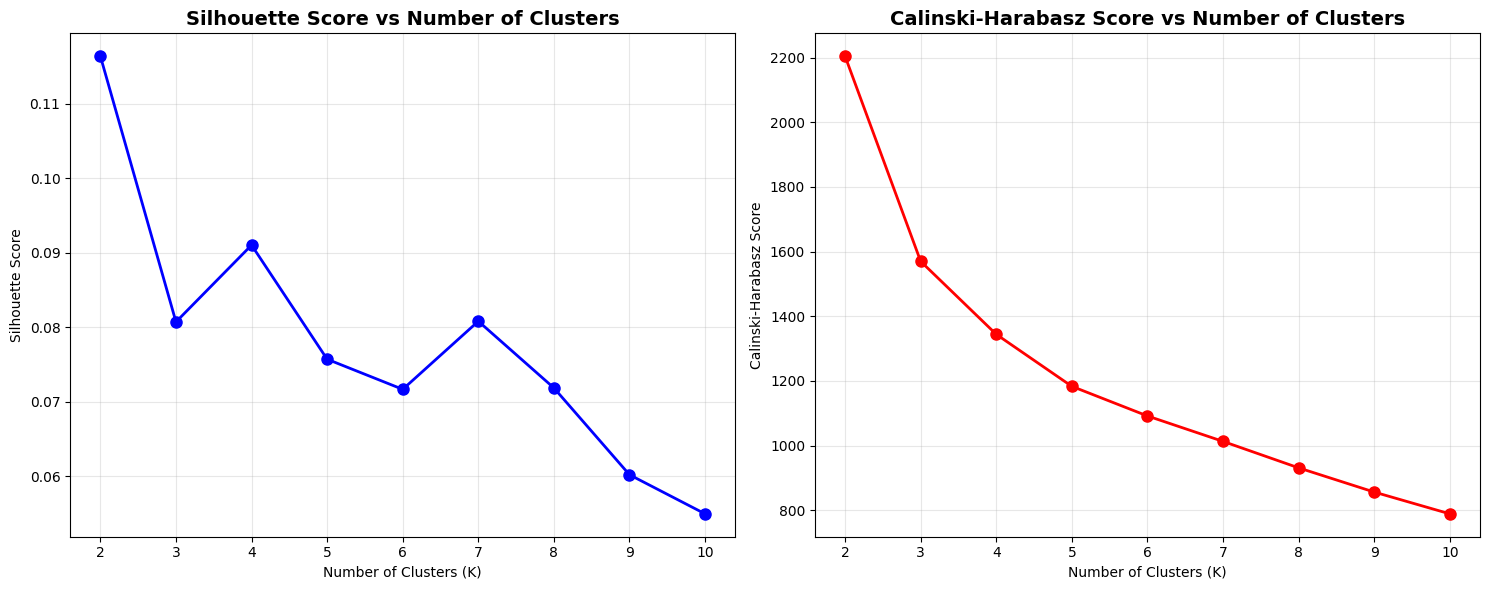


Optimal K based on Silhouette Score: 2 (Score: 0.1164)
Optimal K based on Calinski-Harabasz Score: 2 (Score: 2204.0531)
Optimal K based on Davies-Bouldin Score: 2 (Score: 2.4110)

The following K values are all optimal (based onCalinski-Harabasz Score > 1000):
  K = 2: 2204.0531
  K = 3: 1569.6598
  K = 4: 1343.9607
  K = 5: 1183.0753
  K = 6: 1091.4806
  K = 7: 1012.8108


In [21]:
elbow = elbow_method_analysis(scaled_features)

Silhouette Score works by comparing how similar an object is to its own cluster (cohesion) compared to other clusters (separation). And for this it uses distance based calculations. But our data is having high-dimensional and complex feature spaces (like LDA topics, GloVe embeddings, and text stats) , where traditional distance-based clustering metrics (like silhouette or Davies-Bouldin) can be misleading. So we cannot consider silhouette score for our case.

Whereas Calinski-Harabasz Score provides ratio of between-cluster dispersion to within-cluster dispersion. Normally a score of 1000 and above is considered as relatively well-separated clusters.

And in our case as we already have a requirement that articles need to be clustered in 5 clusters and as we see the Calinski-Harabasz Score for 5 clusters is 1183, which is above 1000, so we can use n_clusters=5 in our clustering model.

As per Calinski-Harabasz Score k value with 5 falls in the optimised clusters, so we can use 5 clusters for our algorithm.

#### 8.1.2 - Apply K-means clustering with 5 clusters

Use Grid search CV for hyperparameter tuning

In [ ]:

# Define the parameter grid
param_grid = {
    'n_clusters': [5], # Based on requirement and elbow method we are fine with 5 clusters
    'init': ['k-means++', 'random'],
    'n_init': [5, 10, 15],
    'max_iter': [100, 200, 300, 400, 500],
    'tol': [0.0001, 0.001, 0.01],
    'algorithm': ['auto', 'full', 'elkan'],
    'random_state': [0, 42, 100]
}

# Create the KMeans object
kmeans = KMeans(random_state=42)

# Perform grid search
grid_search = GridSearchCV(kmeans, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(scaled_features)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)
print('Optimal number of clusters based on parameter grid: ' + str(grid_search.best_params_['n_clusters']))

Best hyperparameters:  {'algorithm': 'elkan', 'init': 'random', 'max_iter': 100, 'n_clusters': 5, 'n_init': 5, 'random_state': 42, 'tol': 0.01}
Optimal number of clusters based on parameter grid: 5


Apply k means using the tuned parameters

In [27]:

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, 
algorithm = 'elkan',
init = 'random',
max_iter = 100,
n_init = 5,
tol = 0.01,
random_state=42
)


# Lets make a copy of the original data frame for kmeans clustering
kmeans_df = df.copy()

# Apply K-means clustering and add the predicted cluster labels to the data frame
kmeans_df['cluster'] = kmeans.fit_predict(scaled_features)



Visualize the predicted data in 2D space using t-SNE

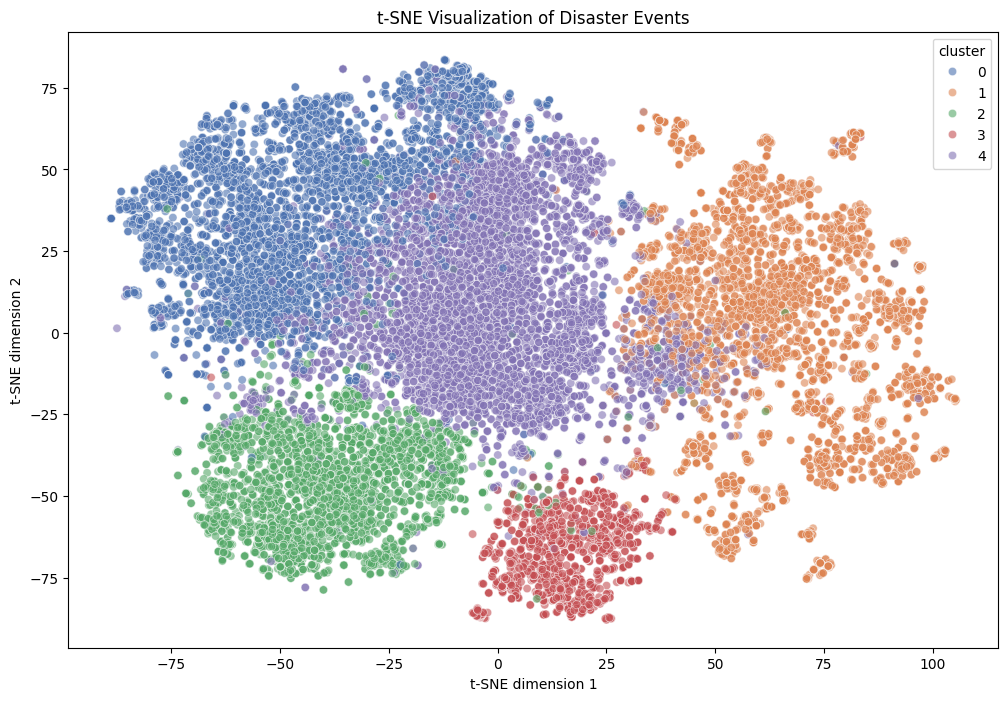

In [28]:

# Create visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=kmeans_df,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='deep',
    alpha=0.6
)
plt.title('t-SNE Visualization of Disaster Events')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

From the visualisation, we can see that the clusters are well formed and are well separated.
- Also can see there is slight overlap between cluster 0 and 4 (This can be due to overlap of disaster keywords). We can analyse this in next steps.

##### Display Sample Events from Each Cluster predicted by KMeans

In [29]:
# Display sample events from each cluster
for cluster in range(5):
    print(f"\nCluster {cluster} examples:")
    sample_events = kmeans_df[kmeans_df['cluster'] == cluster]['cleaned_title'].head(4)
    for idx, event in enumerate(sample_events, 1):
        print(f"{idx}. {event}")


Cluster 0 examples:
1. 2023 finishes as 3rd warmest in central indiana most tornadoes statewide since 2011
2. myrtle beach area neighborhood finds support after tornado
3. organizers 2024 will be the last year of the joplin memorial run a run that started after the 2011 tornado
4. storm henk is there a tornado warning in the united kingdom

Cluster 1 examples:
1. map earthquake strikes japan
2. sumedang hit by 4 8 earthquake from unmapped fault bmkg
3. live updates japan earthquake 7 5 magnitude quake hits triggering tsunami warning
4. madhya pradesh earthquake of magnitude 3 6 hits singrauli

Cluster 2 examples:
1. new state report wildfire smoke increased death rate in spokane across washington
2. tourism trauma collide in wildfire scarred maui
3. tourism is mixed blessing for lahaina community still recovering from deadly wildfires
4. berkshire utility sells 3 8 billion bond to pay wildfire claims

Cluster 3 examples:
1. in photos nasa juno flies just 930 miles above volcanoes on j

Observations:

Based on above sample data.

- Cluster 0: Contains events related to Tornadoes
- Cluster 1: Contains events related to Earthquakes
- Cluster 2: Contains events related to Wildfires
- Cluster 3: Contains events related to Volcanoes
- Cluster 4: Contains events related to Floods

It can be seen that our model is able to group the events into 5 clusters with a high degree of accuracy. 

We can evaluate the overall model accuracy in next steps.

#### 8.1.3 -  Evaluation of KMeans Clustering
KMeans Clustering now clustered the data. And we will evaluate the clusters based on the following metrics:

1. Calinski-Harabasz Score
2. Classification matrix based on rule based clustering vs predictions from kmeans clustering
    - Name predicted Clusters based on observations into [Earthquake, Floods, Volcano, Tornado, Wildfire].
    - Create simple Rule based label to our dataframe based on disaster keywords.
    - Compare Rule based label with KMeans predicted label and calculate accuracy and other metrics.

##### 1. Calinski-Harabasz Score
- As already discussed in previous steps, as we are using high-dimensional and complex feature spaces (like LDA topics, GloVe embeddings, and text stats) for our model, and traditional distance-based clustering metrics (like silhouette or Davies-Bouldin) can be misleading, so we cannot consider them.
- Whereas Calinski-Harabasz Score provides ratio of between-cluster dispersion to within-cluster dispersion. So we can use this to evaluate our clusters. 
- Normally a score of 1000 and above is considered as relatively well-separated clusters.

In [30]:

# we will use the Calinski-Harabasz score to evaluate the quality of the clusters

ch_score = calinski_harabasz_score(scaled_features, kmeans_df['cluster'])

print(f"Calinski-Harabasz Score: {ch_score:.2f}")



Calinski-Harabasz Score: 1178.43


This shows that k means clustering with 5 clusters is well suited.

#### 2. Name KMeans predicted clusters based on observations

From our previous observation we can name clusters as follows:

- Cluster 0: Tornadoes
- Cluster 1: Earthquakes
- Cluster 2: Wildfires
- Cluster 3: Volcanoes
- Cluster 4: Floods



In [31]:
cluster_mapping = {
    0: 'tornado',
    1: 'earthquake',
    2: 'wildfire',      
    3: 'volcano',   
    4: 'floods'   
}

kmeans_df['predicted_cluster'] = kmeans_df['cluster'].map(cluster_mapping)

In [32]:
kmeans_df.head(2)

,title,cleaned_title,is_natcat,lemmatised_title,word_count,avg_word_length,unique_words,unique_word_ratio,char_count,tsne_1,tsne_2,cluster,predicted_cluster
0,Japan earthquakes : Coastal residents told to ...,japan earthquakes coastal residents told to ev...,True,earthquake coastal resident tell evacuate amid...,9,7.000000,9,1.0,71,35.539017,5.652408,4,floods
1,New state report : Wildfire smoke increased de...,new state report wildfire smoke increased deat...,True,new state report wildfire smoke increase death...,9,5.666667,9,1.0,59,-25.941067,-65.444649,2,wildfire


#### 3. Create Rule based Labeling
- Check if following words exists in title, so that we can categorise the title into one of the following categories:
    - earthquake
    - floods
    - tornado
    - volcano
    - wildfire

This helps to compare the k-means clusters with rule based labels and evaluate the performance of k-means clustering.

In [33]:
kmeans_df['rule_based_disaster_cluster'] = kmeans_df['cleaned_title'].apply(rule_label)

#### 4. Create a Confusion matrix to compare the performance of k-means model.

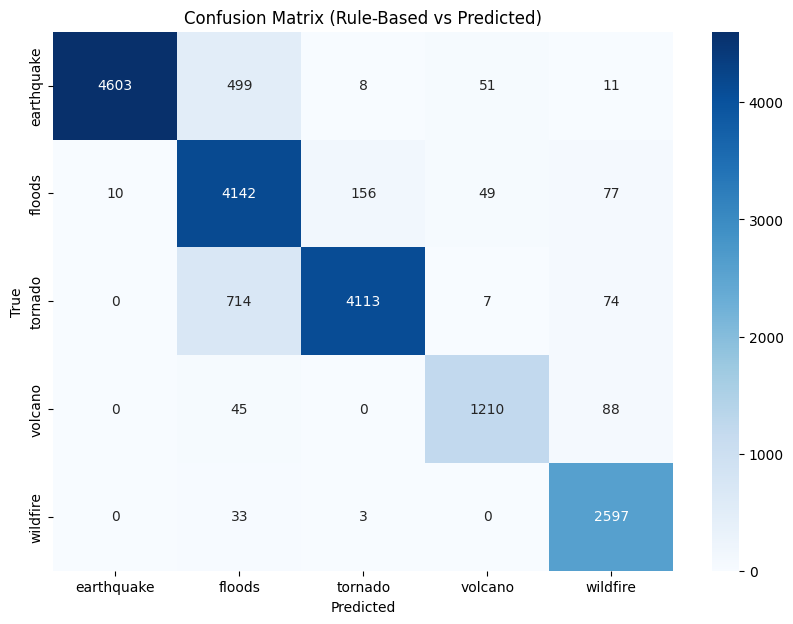

In [34]:

# Consider rule-based disaster cluster as true labels
true_labels = kmeans_df['rule_based_disaster_cluster']

# Consider k-means predicted cluster as predicted labels
predicted_labels = kmeans_df['predicted_cluster']

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get unique classes for labeling
classes = sorted(true_labels.unique())

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, 
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Rule-Based vs Predicted)')
plt.show()

In [35]:
print(classification_report(true_labels, predicted_labels, target_names=classes))

              precision    recall  f1-score   support

  earthquake       1.00      0.89      0.94      5172
      floods       0.76      0.93      0.84      4434
     tornado       0.96      0.84      0.90      4908
     volcano       0.92      0.90      0.91      1343
    wildfire       0.91      0.99      0.95      2633

    accuracy                           0.90     18490
   macro avg       0.91      0.91      0.91     18490
weighted avg       0.91      0.90      0.90     18490



Evaluation of the clustering wrt to Rule based classification:
- It can be seen that the k-means clustering is having an `accuracy of 90%` (90% of the data is correctly classified).
- Also Precision for (earthquake, tornado, volcano, wildfire) is greater than 0.9 and for earthquake as 1, which says that the model is performing well in identifying these categories.And for floods, the precision is 0.76, which is still good.
- F1-Score for (earthquake, tornado, volcano, wildfire) is greater than 0.9, which says that the model is performing well in terms of precision and recall in identifying these categories.

Lets observe few cases manually

In [36]:

kmeans_df[(kmeans_df['rule_based_disaster_cluster']=='tornado') 
& (kmeans_df['predicted_cluster']=='floods')].head(5)


,title,cleaned_title,is_natcat,lemmatised_title,word_count,avg_word_length,unique_words,unique_word_ratio,char_count,tsne_1,tsne_2,cluster,predicted_cluster,rule_based_disaster_cluster
153,Storm clean - up continues in Queensland,storm clean up continues in queensland,True,storm clean continue queensland,4,7.000000,4,1.0,31,0.209732,25.018211,4,floods,tornado
202,Storm Henk : Man dies in Gloucestershire as di...,storm henk man dies in gloucestershire as disr...,True,storm henk man die gloucestershire disruption ...,9,6.777778,9,1.0,69,-13.961671,31.460310,4,floods,tornado
212,Storm Henk : Disruption continues across south...,storm henk disruption continues across south e...,True,storm henk disruption continue england,5,6.800000,5,1.0,38,-14.510387,30.869698,4,floods,tornado
213,Storm Henk leaves roads under water as more ra...,storm henk leaves roads under water as more ra...,True,storm henk leave road under water rain hit sto...,11,4.545455,11,1.0,60,-12.304619,19.955179,4,floods,tornado
221,Travel chaos continues after Storm Henk causes...,travel chaos continues after storm henk causes...,True,travel chaos continue after storm henk cause s...,10,6.000000,10,1.0,69,-14.869908,31.183964,4,floods,tornado


Example:
- Title : Storm Henk leaves roads under water as more rain hits
- Rule based label : Tornado
- Predicted label : Flood

Eventhough the title is about a tornado, the predicted label is flood. This is because the title mentions "roads under water" which is a clear indicator of a flood, and therefore model predicted flood.

Model is trained on semantic relationship between words and as the title is having words related to Tornado and Flood, model gave precedence to semantic meaning of the words and predicted as Flood.



#### 5. Save K-means model weights
- This helps to load the model and make predictions in the future.

In [39]:
# Save K-means model using joblib
save_model(kmeans, '../data/model_weights/kmeans_weights.joblib', use_joblib=True)

# Save K-means model using pickle
save_model(kmeans, '../data/model_weights/kmeans_weights.pickle', use_joblib=False)


Model saved to ../data/model_weights/kmeans_weights.joblib
Model saved to ../data/model_weights/kmeans_weights.pickle


In [40]:
# Save predictions to csv

kmeans_df[['title', 'cleaned_title', 'lemmatised_title', 'rule_based_disaster_cluster',
'predicted_cluster']].to_csv("../data/model_predictions/kmeans_predictions.csv", index=False)


### 8.2 Agglomerative Clustering
Agglomerative clustering is a hierarchical clustering method that builds a hierarchy of clusters from the bottom up. It starts with each data point as its own cluster and then iteratively merges the closest pairs of clusters until all points are in a single cluster. This process creates a dendrogram, a tree-like structure that visualizes the hierarchical relationships between clusters. 

#### Hyperparameter tuning for Agglomerative Clustering

In [ ]:

def tune_agglomerative(X):
    param_grid = {
        'n_clusters': [5],
        'metric': ['euclidean', 'manhattan', 'cosine'],
        'linkage': ['ward', 'complete', 'average', 'single']
    }

    results = []
    for params in itertools.product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        
        # Skip invalid combos: 'ward' requires 'euclidean'
        if param_dict['linkage'] == 'ward' and param_dict['metric'] != 'euclidean':
            continue
        
        model = AgglomerativeClustering(**param_dict)
        labels = model.fit_predict(X)
        
        # Skip if only 1 cluster is formed
        if len(set(labels)) == 1:
            continue
        
        score = calinski_harabasz_score(X, labels)
        results.append((param_dict, score))
    
    # Find best
    best_params, best_score = max(results, key=lambda x: x[1])
    return best_params, best_score, results



In [ ]:
# # Run tuning
# agg_best_params, agg_best_score, agg_all_results = tune_agglomerative(scaled_features)

# print("Best Parameters:", agg_best_params)
# print("Best Calinski-Harabasz Score:", agg_best_score)

Best Parameters: {'n_clusters': 5, 'metric': 'euclidean', 'linkage': 'ward'}
Best Calinski-Harabasz Score: 1062.757142507062


#### Apply Agglomerative Clustering with best parameters

In [41]:
# Apply K-means clustering
agg = AgglomerativeClustering(
n_clusters=5, 
metric = 'euclidean',
linkage = 'ward',
)


# Lets make a copy of the original data frame for kmeans clustering
agg_df = df.copy()

# Apply K-means clustering and add the predicted cluster labels to the data frame
agg_df['cluster'] = agg.fit_predict(scaled_features)


#### Visualization of clusters predicted by Agglomerative Clustering

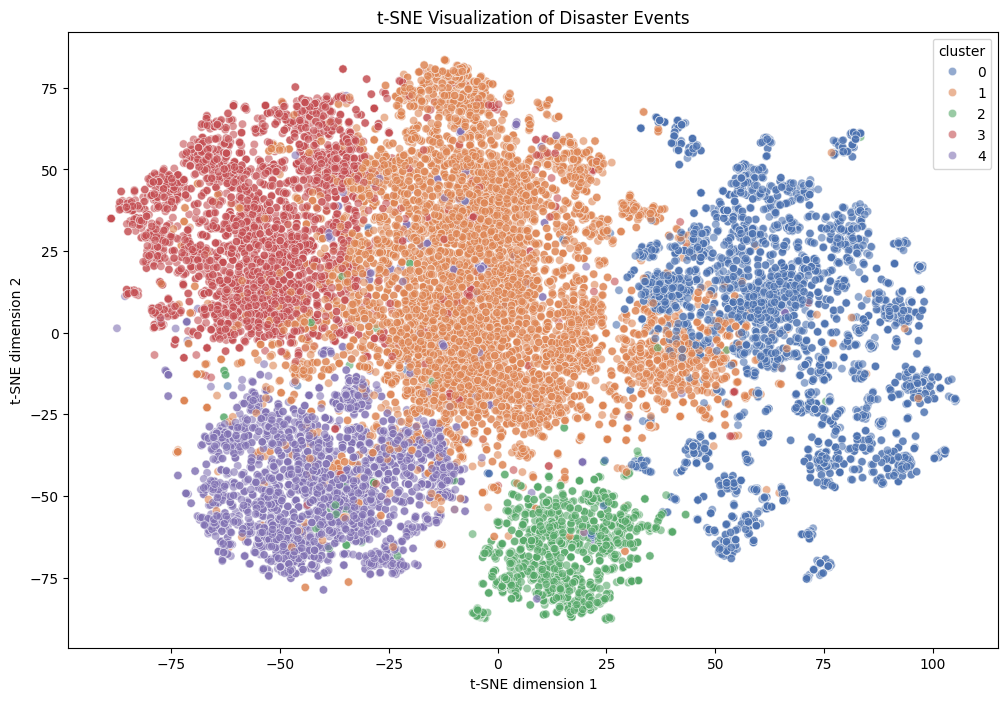

In [42]:
# Create visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=agg_df,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='deep',
    alpha=0.6
)
plt.title('t-SNE Visualization of Disaster Events')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

Display few article titles across all the clusters 

In [43]:
display_cluster_samples(agg_df, 5, 'cluster')


Cluster 0 examples:
1. map earthquake strikes japan
2. massive earthquake slams japan residents flee some coastal areas
3. live updates japan earthquake 7 5 magnitude quake hits triggering tsunami warning
4. madhya pradesh earthquake of magnitude 3 6 hits singrauli

Cluster 1 examples:
1. japan earthquakes coastal residents told to evacuate amid tsunami warnings national
2. new year day flood alerts issued in cambridgeshire as river levels rise
3. widely wet start to new year expected with flood warnings across united kingdom
4. in photos japan hit by massive earthquake on new year day

Cluster 2 examples:
1. in photos nasa juno flies just 930 miles above volcanoes on jupiter violent moon
2. ireland is surrounded by volcanoes
3. thousands evacuated following indonesia volcano eruption
4. northern mariana islands volcano observatory issues activity notice for ahyi seamount maui now

Cluster 3 examples:
1. 2023 finishes as 3rd warmest in central indiana most tornadoes statewide since 20

Observations:
- Cluster 0: Contains titles related to earthquakes. 
- Cluster 1: Contains titles related to Floods (But have earthquake as well)
- Cluster 2: Contains titles related to Volcanoes.
- Cluster 3: Contains titles related to Tornadoes. (But have few flood related titles as well)
- Cluster 4: Contains titles related to Wildfires (But have few Flood related titles as well)


From basic observation we can see that the model is not able to differentiate Floods correctly. This can be observed from the t-SNE visualisation as well.

### Evaluation of Agglomerative Clustering
- Similar to KMeans, we can use the same metrics to evaluate the performance of the model.

#### 1. calinski_harabasz_score

In [46]:

ch_score_agg = calinski_harabasz_score(scaled_features, agg_df['cluster'])

print(f"Calinski-Harabasz Score: {ch_score_agg:.2f}")

Calinski-Harabasz Score: 1062.76


A score of above 1000 is considered good and we received 1062, so its considered good fit.

#### 2. Evalaute model prediction against Rule based label 

In [45]:
agg_df['rule_based_disaster_cluster'] = agg_df['cleaned_title'].apply(rule_label)

In [47]:
agg_cluster_mapping = {
    0: 'earthquake',
    1: 'floods',
    2: 'volcano',
    3: 'tornado',
    4: 'wildfire'
}

agg_df['predicted_cluster'] = agg_df['cluster'].map(agg_cluster_mapping)

Generate Confusion matrix

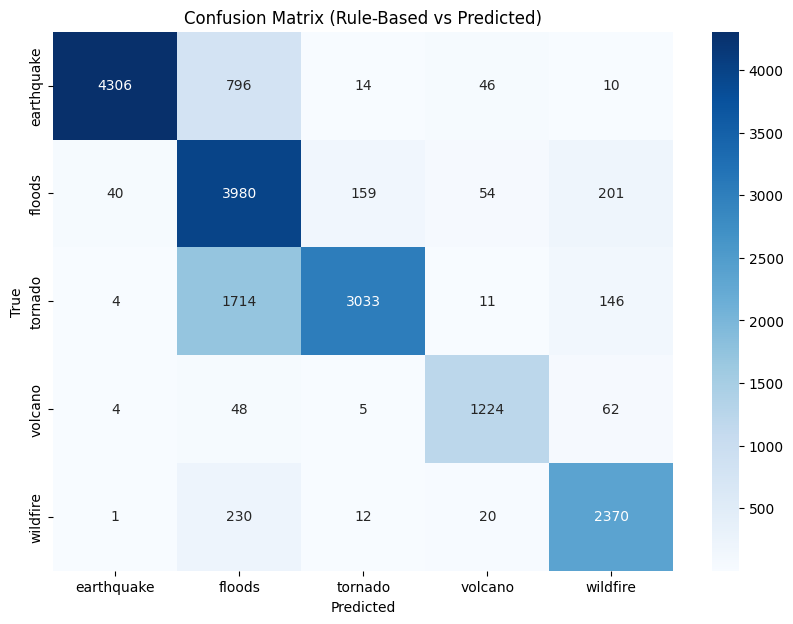

              precision    recall  f1-score   support

  earthquake       0.99      0.83      0.90      5172
      floods       0.59      0.90      0.71      4434
     tornado       0.94      0.62      0.75      4908
     volcano       0.90      0.91      0.91      1343
    wildfire       0.85      0.90      0.87      2633

    accuracy                           0.81     18490
   macro avg       0.85      0.83      0.83     18490
weighted avg       0.85      0.81      0.81     18490



In [68]:
agg_confusion_matrix = generate_confusion_matrix(agg_df)

Observations:
- Overall Accuracy of 81% can be seen in the model
- Model precision is low for floods identification. Model contains more number of False Positives wrt floods. And is predicting tornadoes and earthquakes as floods.
- Model struggles with the identification of floods and tornadoes.

#### Save model weights

In [50]:
# Save K-means model using joblib
save_model(agg, '../data/model_weights/agglomerative_weights.joblib', use_joblib=True)

# Save K-means model using pickle
save_model(agg, '../data/model_weights/agglomerative_weights.pickle', use_joblib=False)

Model saved to ../data/model_weights/agglomerative_weights.joblib
Model saved to ../data/model_weights/agglomerative_weights.pickle


In [51]:
# Save predictions to csv

agg_df[['title', 'cleaned_title', 'lemmatised_title', 'rule_based_disaster_cluster',
'predicted_cluster']].to_csv("../data/model_predictions/Agglomerative_predictions.csv", index=False)

### 8.3 Gaussian Mixture Model (GMM)
A Gaussian Mixture Model (GMM) is a probabilistic model that represents data as a combination of multiple Gaussian (normal) distributions. Each Gaussian component has its own mean and covariance, and the overall data distribution is a weighted sum of these components.

In [ ]:
# Hyperparameter tuning for Gaussian Mixture Models (GMM)
def tune_gmm(X):
    """
    Hyperparameter tuning for Gaussian Mixture Models using Calinski–Harabasz score.
    Returns the best parameters, best score, and all results.
    """
    param_grid = {
        'n_components': [5],  
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': [0.0001, 0.001, 0.01],
        'reg_covar': [1e-06, 1e-05, 1e-04],
        'max_iter': [100, 200, 300],
        'init_params': ['kmeans', 'random'],
        'random_state': [0, 42]
    }
    
    results = []
    for params in itertools.product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        
        try:
            model = GaussianMixture(**param_dict)
            labels = model.fit_predict(X)
            
            # Skip if model collapses to 1 cluster
            if len(set(labels)) == 1:
                continue
            
            score = calinski_harabasz_score(X, labels)
            results.append((param_dict, score))
        
        except Exception as e:
            # Skip failed runs
            continue
    
    # Select the best
    best_params, best_score = max(results, key=lambda x: x[1])
    return best_params, best_score, results



In [ ]:
# # Apply GMM tuning:
# gmm_best_params, gmm_best_score, gmm_all_results = tune_gmm(scaled_features)
# print("Best Parameters:", gmm_best_params)
# print("Best Calinski-Harabasz Score:", gmm_best_score)


In [52]:
# Apply GMM clustering with below parameters
gmm_model = GaussianMixture(
    n_components=5,
    random_state=42,
    covariance_type='tied'
)

gmm_df = df.copy()

# Apply GMM clustering and add the predicted cluster labels to the data frame
gmm_df['cluster'] = gmm_model.fit_predict(scaled_features)

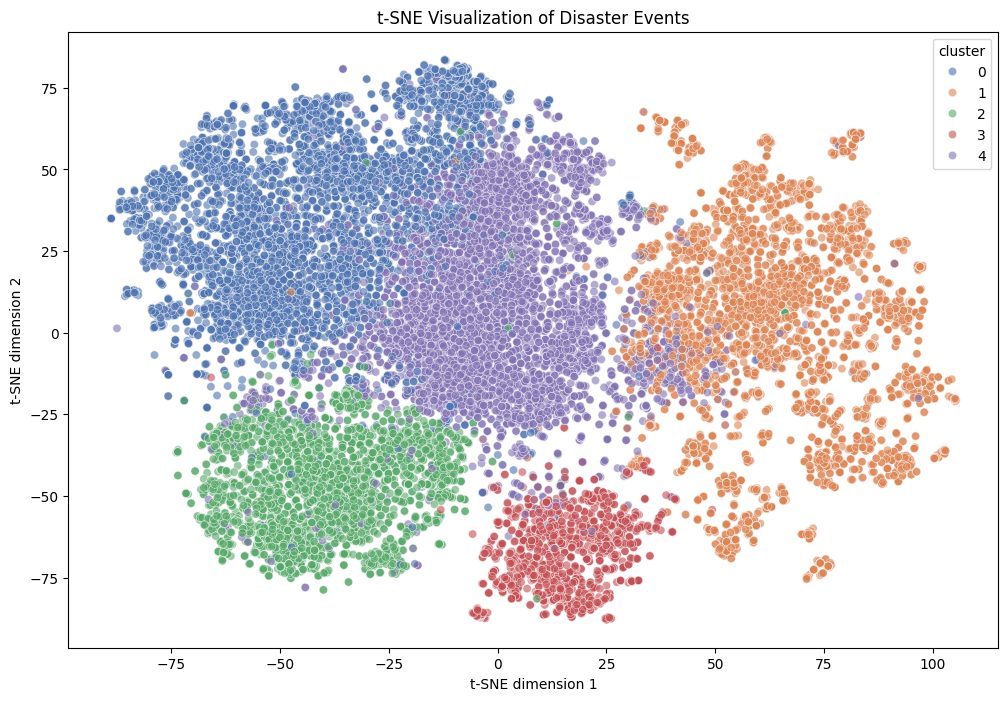

In [53]:
# Create visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=gmm_df,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='deep',
    alpha=0.6
)
plt.title('t-SNE Visualization of Disaster Events')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

In [54]:
# Display sample events from each cluster
display_cluster_samples(gmm_df, 5, 'cluster')


Cluster 0 examples:
1. 2023 finishes as 3rd warmest in central indiana most tornadoes statewide since 2011
2. myrtle beach area neighborhood finds support after tornado
3. organizers 2024 will be the last year of the joplin memorial run a run that started after the 2011 tornado
4. storm henk is there a tornado warning in the united kingdom

Cluster 1 examples:
1. japan earthquakes coastal residents told to evacuate amid tsunami warnings national
2. in photos japan hit by massive earthquake on new year day
3. map earthquake strikes japan
4. sumedang hit by 4 8 earthquake from unmapped fault bmkg

Cluster 2 examples:
1. new state report wildfire smoke increased death rate in spokane across washington
2. tourism trauma collide in wildfire scarred maui
3. tourism is mixed blessing for lahaina community still recovering from deadly wildfires
4. berkshire utility sells 3 8 billion bond to pay wildfire claims

Cluster 3 examples:
1. in photos nasa juno flies just 930 miles above volcanoes on

Observations:
- Cluster 0: Contains titles related to Tornadoes. 
- Cluster 1: Contains titles related to Earthquakes.
- Cluster 2: Contains titles related to Wildfires.
- Cluster 3: Contains titles related to Volcanoes.
- Cluster 4: Contains titles related to Floods.


From basic observation we can see that the model is best fit and all the categories are well categorised. Lets see evaluation and further analysis to see if there are differences. 

### Evalaution of GMM Model

#### 1. Calinski-Harabasz Score

In [55]:
ch_score_gmm = calinski_harabasz_score(scaled_features, gmm_df['cluster'])

print(f"Calinski-Harabasz Score: {ch_score_gmm:.2f}")

Calinski-Harabasz Score: 1150.49


A score of 1150 is observation, which is a good score

#### 2. Compare with Rule based

In [56]:
gmm_df['rule_based_disaster_cluster'] = gmm_df['cleaned_title'].apply(rule_label)

In [58]:
# Name Clusters as per observations
gmm_cluster_mapping = {
    0: 'tornado',
    1: 'earthquake',
    2: 'wildfire',
    3: 'volcano',
    4: 'floods'
}

gmm_df['predicted_cluster'] = gmm_df['cluster'].map(gmm_cluster_mapping)

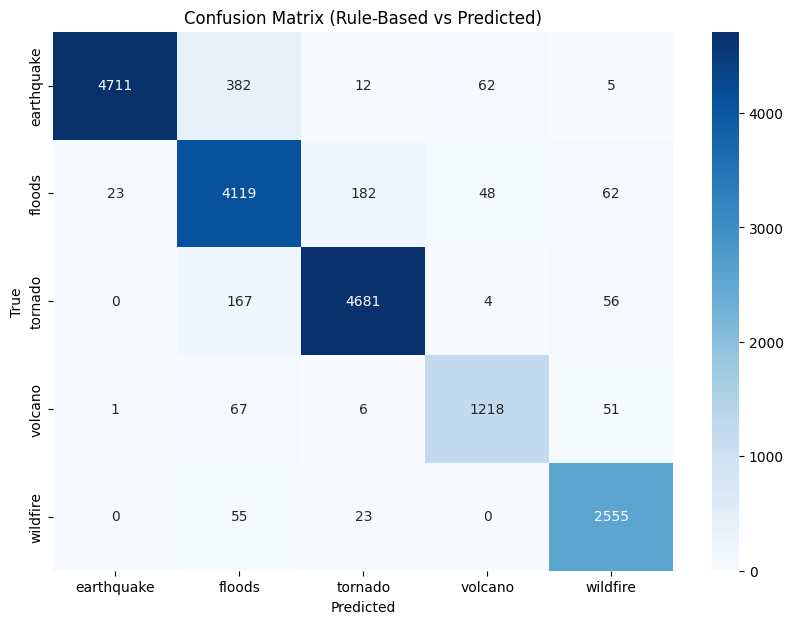

              precision    recall  f1-score   support

  earthquake       0.99      0.91      0.95      5172
      floods       0.86      0.93      0.89      4434
     tornado       0.95      0.95      0.95      4908
     volcano       0.91      0.91      0.91      1343
    wildfire       0.94      0.97      0.95      2633

    accuracy                           0.93     18490
   macro avg       0.93      0.93      0.93     18490
weighted avg       0.94      0.93      0.94     18490



In [69]:
# Generate Confusion Matrix
gmm_confusion_matrix = generate_confusion_matrix(gmm_df)

Observations:
- Seems this is the best fit compared to all the above models so far.
- Accuracy of 93%, with precision greater than 0.91 for all classes except floods.
- Recall can be seen greater than 0.9 for all the clusters, which is a very good indication that there are very less False Negatives.

In [60]:
# Save K-means model using joblib
save_model(gmm_model, '../data/model_weights/gmm_weights.joblib', use_joblib=True)

# Save K-means model using pickle
save_model(gmm_model, '../data/model_weights/gmm_weights.pickle', use_joblib=False)

Model saved to ../data/model_weights/gmm_weights.joblib
Model saved to ../data/model_weights/gmm_weights.pickle


In [61]:
# Save predictions to csv

gmm_df[['title', 'cleaned_title', 'lemmatised_title', 'rule_based_disaster_cluster',
'predicted_cluster']].to_csv("../data/model_predictions/GMM_predictions.csv", index=False)

## Compare all clustering models

Please go through the `Evaluations.docx` file in `reports` folder, where I have compared all the metrics of the above 3 models in a single document.
And based on all the metrics GMM model performs better followed by K-means and Agglomerative.